In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import random_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import from_networkx, to_networkx
from scipy.sparse import csr_matrix
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from nilearn import datasets, plotting

In [2]:
loaded_data = torch.load('../../ppmi.pth')
data_tensor = loaded_data['data'].to(dtype=torch.float32)
class_label = loaded_data['class_label']
aal_atlas = datasets.fetch_atlas_aal(version='SPM12')
atlas_filename = aal_atlas.maps
labels = aal_atlas.labels
coords = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)
colors = [
    '#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#800000', '#808000', '#008000', '#800080',
    '#008080', '#000080', '#FF4500', '#DA70D6', '#7FFF00', '#D2691E', '#FF69B4', '#8A2BE2', '#5F9EA0', '#D2B48C',
    '#FFE4B5', '#BDB76B', '#F0E68C', '#FFD700', '#ADFF2F', '#32CD32', '#98FB98', '#AFEEEE', '#4682B4', '#6A5ACD',
    '#7B68EE', '#00FA9A', '#48D1CC', '#6495ED', '#1E90FF', '#FF6347', '#FF7F50', '#F08080', '#E9967A', '#FA8072',
    '#FF1493', '#C71585', '#DB7093', '#B22222', '#FF4500', '#DAA520', '#B8860B', '#CD5C5C', '#4B0082', '#FF8C00',
    '#FFDAB9', '#E6E6FA', '#FFF0F5', '#FFE4E1', '#FAEBD7', '#F5F5DC', '#FFFACD', '#FFEBCD'
]

In [3]:
def normalize_correlation_matrix(matrix):
    """
    Normalize a correlation matrix to the range [-1, 1].
    
    :param matrix: A numpy array or PyTorch tensor representing the correlation matrix.
    :return: A normalized correlation matrix of the same type (numpy array or PyTorch tensor).
    """
    if isinstance(matrix, np.ndarray):
        max_val = np.max(matrix)
        min_val = np.min(matrix)
        normalized_matrix = 2 * (matrix - min_val) / (max_val - min_val) - 1
    elif isinstance(matrix, torch.Tensor):
        max_val = torch.max(matrix)
        min_val = torch.min(matrix)
        normalized_matrix = 2 * (matrix - min_val) / (max_val - min_val) - 1
    else:
        raise TypeError("Input must be a numpy array or a PyTorch tensor.")
    return normalized_matrix

In [4]:
def construct_graph(correlation_matrix, threshold=0.5):
    num_regions = correlation_matrix.shape[0]
    # Create NetworkX graph to utilize its easy manipulation capabilities
    G = nx.Graph()
    # Add nodes with alternating hemispheres based on AAL116 atlas
    for i in range(num_regions):
        hemisphere = 'left' if i % 2 == 0 else 'right'
        color = colors[i//2]
        G.add_node(i, hemisphere=hemisphere, coords=coords[i], label=labels[i], color=color)
    # Add edges
    for i in range(num_regions):
        for j in range(i + 1, num_regions):
            if abs(correlation_matrix[i, j]) > threshold:
                G.add_edge(i, j, weight=correlation_matrix[i, j])
    return G

In [5]:
def adj_to_graphs(data_tensor, batch_size=32, threshold=0.5):
    graphs = []
    num_batches = (data_tensor.shape[0] + batch_size - 1) // batch_size
    for batch_idx in tqdm(range(num_batches), desc="Processing batches"):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, data_tensor.shape[0])
        batch_graphs = []
        for i in range(start_idx, end_idx):
            if torch.isnan(data_tensor[i]).any() or torch.isinf(data_tensor[i]).any():
                print(f"Matrix {i+1} contains NaN or Inf values. Skipping.")
                continue
            try:
                normalized_matrix = normalize_correlation_matrix(data_tensor[i].to(dtype=torch.float32))  # Ensure float32
                graph = construct_graph(normalized_matrix, threshold)
                batch_graphs.append(graph)
            except Exception as e:
                print(f"Error processing matrix {i+1}: {e}")
        graphs.extend(batch_graphs)
        # Clear batch variables to free memory
        del batch_graphs
        torch.cuda.empty_cache()  # Clear GPU memory if using GPU
    return graphs

In [6]:
graphs = adj_to_graphs(data_tensor)

Processing batches: 100%|██████████| 7/7 [00:26<00:00,  3.77s/it]


In [7]:
def emphasize_and_filter_interhemispheric_edges(G, emphasis_factor=1, percentage_threshold=10):
    """
    Emphasizes the weights of interhemispheric edges and drops edges below a certain percentage threshold.
    Also removes nodes that no longer have connections after filtering.
    
    :param G: NetworkX graph
    :param emphasis_factor: Factor by which to multiply the weights of interhemispheric edges
    :param percentage_threshold: Percentage threshold to filter edges (0-100)
    :return: Modified NetworkX graph with emphasized and filtered interhemispheric edges
    """
    filtered_G = G.copy()
    # Get all edge weights
    weights = [abs(data['weight']) for u, v, data in filtered_G.edges(data=True)]
    
    # Determine the weight threshold based on the percentage
    weight_threshold = np.percentile(weights, percentage_threshold)
    
    edges_to_remove = []
    print(f"Original: {filtered_G.number_of_nodes()} nodes, {filtered_G.number_of_edges()} edges")
    print(f"Weight threshold based on {percentage_threshold}th percentile: {weight_threshold}")

    for u, v, data in filtered_G.edges(data=True):
        if abs(data['weight']) < weight_threshold:
            edges_to_remove.append((u, v))
        elif filtered_G.nodes[u]['hemisphere'] != filtered_G.nodes[v]['hemisphere']:
            filtered_G[u][v]['weight'] *= emphasis_factor

    # Remove edges that are below the threshold
    filtered_G.remove_edges_from(edges_to_remove)

    # Identify and remove nodes that no longer have connections
    nodes_to_remove = [node for node, degree in filtered_G.degree() if degree == 0]
    filtered_G.remove_nodes_from(nodes_to_remove)

    print(f"Modified: {filtered_G.number_of_nodes()} nodes, {filtered_G.number_of_edges()} edges")
    return filtered_G

In [8]:
def extract_interhemispheric_subgraph(G, emphasis_factor=1, weight_threshold=0.1):
    subgraph = nx.Graph()
    for u, v, data in G.edges(data=True):
        if G.nodes[u]['hemisphere'] != G.nodes[v]['hemisphere']:
            subgraph.add_edge(u, v, weight=data['weight'])
            subgraph.add_node(u, hemisphere=G.nodes[u]['hemisphere'], coords=G.nodes[u]['coords'], label=G.nodes[u]['label'], color=G.nodes[u]['color'])
            subgraph.add_node(v, hemisphere=G.nodes[v]['hemisphere'], coords=G.nodes[v]['coords'], label=G.nodes[v]['label'], color=G.nodes[v]['color'])
    return emphasize_and_filter_interhemispheric_edges(subgraph, emphasis_factor, weight_threshold)

In [9]:
def extract_intrahemispheric_subgraph(G, emphasis_factor=1, weight_threshold=0.1):
    subgraph = nx.Graph()
    for u, v, data in G.edges(data=True):
        if G.nodes[u]['hemisphere'] == G.nodes[v]['hemisphere']:
            subgraph.add_edge(u, v, weight=data['weight'])
            subgraph.add_node(u, hemisphere=G.nodes[u]['hemisphere'], coords=G.nodes[u]['coords'], label=G.nodes[u]['label'], color=G.nodes[u]['color'])
            subgraph.add_node(v, hemisphere=G.nodes[v]['hemisphere'], coords=G.nodes[v]['coords'], label=G.nodes[v]['label'], color=G.nodes[v]['color'])
    return emphasize_and_filter_interhemispheric_edges(subgraph, emphasis_factor, weight_threshold)

In [29]:
sub_graph = extract_interhemispheric_subgraph(graphs[0], 1, 99.5)
sub_graph_adj = nx.adjacency_matrix(sub_graph).todense()
sub_graph_coords = [sub_graph.nodes[node]['coords'] for node in sub_graph.nodes()]
sub_graph_colors = [sub_graph.nodes[node]['color'] for node in sub_graph.nodes()]
print(sub_graph_adj.shape)
print(len(sub_graph_coords))
print(len(sub_graph_colors))

Original: 116 nodes, 1577 edges
Weight threshold based on 99.5th percentile: 0.9999026560783386
Modified: 16 nodes, 8 edges
(16, 16)
16
16


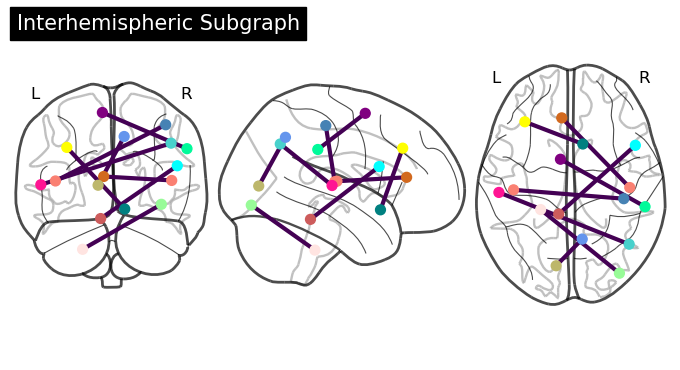

In [30]:
plotting.plot_connectome(adjacency_matrix=sub_graph_adj, node_coords=sub_graph_coords, node_color=sub_graph_colors, edge_cmap='viridis', display_mode='ortho', title='Interhemispheric Subgraph')

In [31]:
sub_graph = extract_intrahemispheric_subgraph(graphs[0], 1, 99.5)
sub_graph_adj = nx.adjacency_matrix(sub_graph).todense()
sub_graph_coords = [sub_graph.nodes[node]['coords'] for node in sub_graph.nodes()]
sub_graph_colors = [sub_graph.nodes[node]['color'] for node in sub_graph.nodes()]
print(sub_graph_adj.shape)
print(len(sub_graph_coords))
print(len(sub_graph_colors))

Original: 116 nodes, 1503 edges
Weight threshold based on 99.5th percentile: 0.9997971266508102
Modified: 16 nodes, 8 edges
(16, 16)
16
16


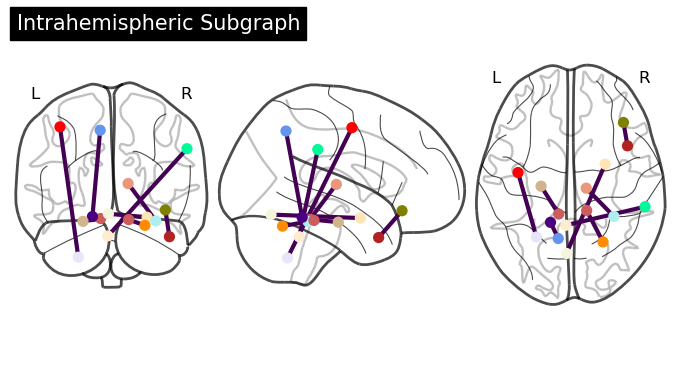

In [33]:
plotting.plot_connectome(adjacency_matrix=sub_graph_adj, node_coords=sub_graph_coords, node_color=sub_graph_colors, edge_cmap='viridis', display_mode='ortho', title='Intrahemispheric Subgraph')

In [ ]:
def process_correlation_matrices(correlation_matrices, threshold=0.5, emphasis_factor=2):
    graphs = []
    interhemispheric_subgraphs = []
    emphasized_graphs = []
    
    for matrix in correlation_matrices:
        pyg_graph = construct_pyg_graph(matrix, threshold)
        subgraph = extract_interhemispheric_subgraph(pyg_graph)
        emphasized_graph = emphasize_interhemispheric_edges(pyg_graph, emphasis_factor)
        
        graphs.append(pyg_graph)
        interhemispheric_subgraphs.append(subgraph)
        emphasized_graphs.append(emphasized_graph)
    
    return graphs, interhemispheric_subgraphs, emphasized_graphs

In [ ]:
def load_data():
    # Assuming correlation_matrices is loaded from some source, e.g., torch.load or np.load
    correlation_matrices = np.load('./data/correlation_matrices.npy')
    
    train_size = int(0.7 * len(correlation_matrices))
    val_size = int(0.15 * len(correlation_matrices))
    test_size = len(correlation_matrices) - train_size - val_size
    
    train_matrices, val_matrices, test_matrices = random_split(correlation_matrices, [train_size, val_size, test_size])
    
    train_graphs, _, _ = process_correlation_matrices(train_matrices)
    val_graphs, _, _ = process_correlation_matrices(val_matrices)
    test_graphs, _, _ = process_correlation_matrices(test_matrices)
    
    batch_size = 64
    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True, num_workers=8)
    val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=True, num_workers=8)
    test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=True, num_workers=8)
    
    return train_loader, val_loader, test_loader

In [ ]:
def main():
    args = parse_args()
    set_seeds()
    device = get_device(args.gpu)
    train_loader, val_loader, test_loader = load_data()
    model = get_model(args.model, args.hidden_channels).to(device)
    num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model: {args.model}, parameters: {num_parameters}")
    
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    
    best_val_acc = 0
    for epoch in range(1, args.epochs + 1):
        loss = train(model, train_loader, criterion, optimizer, device)
        val_acc, _, _, _ = test(model, val_loader, device)
        test_acc, pre, rec, f1 = test(model, test_loader, device)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        print(f'Epoch: {epoch:03d}, best Acc: {best_val_acc:.4f}, Test Acc: {test_acc:.4f}, Loss: {loss:.4f}, pre: {pre:.4f}, rec: {rec:.4f}, f1: {f1:.4f}')

if __name__ == "__main__":
    main()
